<a href="https://colab.research.google.com/github/minotajordan/metaheuristic/blob/main/HC_HCRR_SA_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

myPath = "/content/sample_data/problems/"

In [ ]:
# Plot convergence curve
def plot_convergence_curve(fitness_history, p, alg):
  efos = np.arange(len(fitness_history))
  plt.title("Convergence curve for " + str(p))
  plt.xlabel("EFOs")
  plt.ylabel("Fitness")
  plt.plot(efos, fitness_history, label=str(alg))
  plt.legend()
  plt.show()

# Plot convergence curve comparison for two or more algorithms
def plot_convergence_curve_comparison(fitness_history, p, alg):
  efos = np.arange(len(fitness_history[0]))
  plt.title("Convergence curve for " + str(p))
  plt.xlabel("EFOs")
  plt.ylabel("Fitness")
  algorithms = len(fitness_history)
  for a in range(algorithms):
    plt.plot(efos, fitness_history[a], label=str(alg[a]))
  plt.legend()
  plt.show()

def print_alorithms_with_avg_fitness(alg, avg_fitness):
  rows = len(alg)
  for r in range(rows):
    print(alg[r] + " {0:12.6f}".format(avg_fitness[r]))

In [ ]:
# Download problems at https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html
# Download problems at TSPLIb -> http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/

class tsp:
    size: int

    def __init__(self, filename):
        file1 = open(filename, 'r')
        lines = file1.readlines()

        self.file_name = Path(filename).stem
        self.size = int(lines[0])

        # Coordinate of cities
        x = np.zeros(self.size, float)
        y = np.zeros(self.size, float)
        positionLine = 1
        for i in range(0, self.size):
            lines[positionLine] = lines[positionLine].rstrip() # remove \n
            line = lines[positionLine].split('\t')
            if line[0] != '?':
                x[positionLine - 1] = float(line[0])
                y[positionLine - 1] = float(line[1])
            positionLine = positionLine + 1

        # Distance matrix
        self.distances = np.zeros((self.size, self.size), dtype=float)
        for i in range(0, self.size):
            lines[positionLine] = lines[positionLine].rstrip()  # remove \n
            line = lines[positionLine].split('\t')
            for j in range(0, self.size):
                dis = float(line[j])
                self.distances[i][j] = self.distances[j][i] = dis
            positionLine = positionLine + 1

        # Best known solution (convert to zero based index required)
        self.bestKnown = np.zeros(self.size, dtype=int)
        for i in range(0, self.size):
            lines[positionLine] = lines[positionLine].rstrip()  # remove \n
            line = lines[positionLine].split('\n')
            if line[0] != '?':
                self.bestKnown[i] = int(line[0]) - 1
            positionLine = positionLine + 1

        # Tour length
        line = lines[positionLine].split('\n')
        self.bestFitness = 0
        if line[0] != '?':
            self.bestFitness = float(line[0])

    def distance(self, cityA: int, cityB: int):
        return self.distances[cityA][cityB]  # This problem is symmetric

    def evaluate(self, cells):
        fitness = 0
        for i in range(self.size):
            j = i + 1
            if j >= self.size:
                j = 0
            fitness = fitness + self.distances[cells[i]][cells[j]]
        return fitness

    def __str__(self):
        return self.file_name + ' ' + str(self.bestFitness)

In [ ]:
myP1 = tsp(myPath +"01-easy5.txt")
print (myP1)
print (myP1.distances)
print (myP1.bestKnown)

01-easy5 19.0
[[0. 3. 4. 2. 7.]
 [3. 0. 4. 6. 3.]
 [4. 4. 0. 5. 8.]
 [2. 6. 5. 0. 6.]
 [7. 3. 8. 6. 0.]]
[0 2 1 4 3]


In [ ]:
class solution:
    def __init__(self, p: tsp):
        self.problem = p
        self.cells = np.zeros(self.problem.size, int)
        self.fitness = 0.0

    def from_solution(self, origin):
        self.problem = origin.problem
        self.cells = np.copy(origin.cells)
        self.fitness = origin.fitness

    def Initialization(self):
        self.cells = np.random.choice(self.problem.size, self.problem.size, replace=False)
        self.fitness = self.problem.evaluate(self.cells)

    def tweak(self):
        pos = np.random.choice(np.arange(1, self.problem.size), 2, replace=False)
        pos.sort()
        i = pos[0]
        k = pos[1]
        self.cells[i:k] = self.cells[k - 1:i - 1:-1]
        self.fitness = self.problem.evaluate(self.cells)

    def __str__(self):
        return "cells:" + str(self.cells) + \
               "-fit:" + str(self.fitness)


In [ ]:
myP1 = tsp(myPath +"02-ulysses16.txt")
print (myP1)

s1 = solution (myP1)
s1.Initialization()
print(s1)

s2 = solution (myP1)
s2.from_solution(s1)

print(s2)
s2.tweak()
print(s2)

02-ulysses16 407.82547
cells:[ 7  0  9 15  8  3 10 11 13 14 12  4  2  1  5  6]-fit:776.5120999999999
cells:[ 7  0  9 15  8  3 10 11 13 14 12  4  2  1  5  6]-fit:776.5120999999999
cells:[ 7  0  9 15  8  3 10 11 13 14  1  2  4 12  5  6]-fit:764.06646


In [ ]:
class HC:
    def __init__(self, max_efos: int):
        self.max_efos = max_efos

    def evolve(self, seed: int, problem: tsp):
        self.problem = problem
        np.random.seed (seed)
        best_fitness_history = np.zeros(self.max_efos, float)

        self.best = solution(self.problem)
        self.best.Initialization()
        best_fitness_history[0] = self.best.fitness

        S = self.best # S is a pointer to self.best, not a full copy
        for iteration in range(1, self.max_efos):
            R = solution(S.problem)
            R.from_solution(S) # R is a full copy of S
            R.tweak()
            if R.fitness < S.fitness: # Minimizing
                S.from_solution(R)
            best_fitness_history[iteration] = self.best.fitness
        return best_fitness_history

    def __str__(self):
        result = "HC:"
        return result

02-ulysses16 407.82547


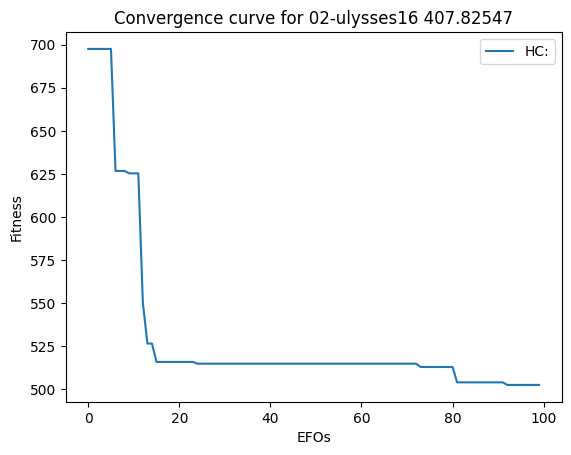

cells:[ 3 13  6 11 12  1  2  9  8 15  0  7 14  4 10  5]-fit:502.63136000000003


In [ ]:
myP1 = tsp(myPath +"02-ulysses16.txt")
print (myP1)
max_efos = 100
hc = HC(max_efos = max_efos)
r1 = hc.evolve(seed=1, problem=myP1)
#print(r1)
plot_convergence_curve(r1, myP1, hc)
print (hc.best)

In [ ]:
class HCRR:
    def __init__(self, max_efos: int, max_local: int):
        self.max_efos = max_efos
        self.max_local = max_local

    def evolve(self, seed: int, problem: tsp):
        self.problem = problem
        np.random.seed (seed)
        best_fitness_history = np.zeros(self.max_efos, float)
        efos = 0
        while efos < self.max_efos:
          S = solution(problem) # S is a new Solution
          S.Initialization() # Random initialization and calculating fitness
          if efos == 0:
            self.best = solution(problem)
            self.best.from_solution(S) # self.best is a full copy of S
            best_fitness_history[0] = self.best.fitness
          # Perform the hill climbig optimization (local)
          for opt in range(1, self.max_local):
              R = solution(S.problem)
              R.from_solution(S) # R is a full copy of S
              R.tweak() # Tweeking and calculating fitness
              if R.fitness < S.fitness: # Minimizing
                  S.from_solution(R)
              if S.fitness < self.best.fitness: # Minimizing
                  self.best.from_solution(S) # self.best is a full copy of S
              best_fitness_history[efos] = self.best.fitness
              efos+=1
              if efos >= self.max_efos:
                break
        return best_fitness_history

    def __str__(self):
        result = "HCRR-maxlocal:" + str(self.max_local)
        return result

02-ulysses16 407.82547


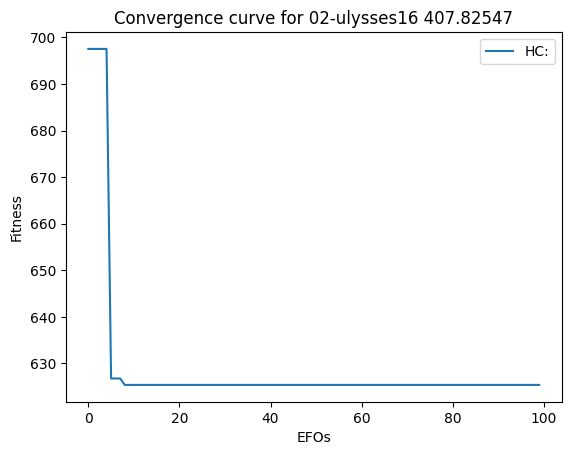

cells:[ 3 13  7  4 10  6 12  8  9 15  0 14  1  2 11  5]-fit:625.36869


In [ ]:
myP1 = tsp(myPath +"02-ulysses16.txt")
print (myP1)
max_efos = 100
max_local = 10
hcrr = HCRR(max_efos = max_efos, max_local=max_local)
r2 = hcrr.evolve(seed=1, problem=myP1)
#print(r2)
plot_convergence_curve(r2, myP1, hc)
print (hcrr.best)

In [ ]:
class SA:
    def __init__(self, max_efos: int):
        self.max_efos = max_efos

    def evolve(self, seed: int, problem: tsp):
        to = 100
        self.problem = problem
        np.random.seed (seed)
        best_fitness_history = np.zeros(self.max_efos, float)

        S = solution(self.problem)
        S.Initialization()
        best_fitness_history[0] = S.fitness
        self.best = solution(self.problem)
        self.best.from_solution(S) # self.best is a full copy of S
        t= to
        for iteration in range(1, self.max_efos):
            R = solution(S.problem)
            R.from_solution(S) # R is a full copy of S
            R.tweak()
            t = t - to/(self.max_efos + 1)
            ale = np.random.uniform()
            prob = math.exp((S.fitness - R.fitness) / t) # Minimizing
            if R.fitness < S.fitness or ale < prob: # Minimizing
                S.from_solution(R)
            if S.fitness < self.best.fitness: # Minimizing
                self.best.from_solution(S)
            best_fitness_history[iteration] = self.best.fitness
        return best_fitness_history

    def __str__(self):
        result = "SA"
        return result

02-ulysses16 407.82547


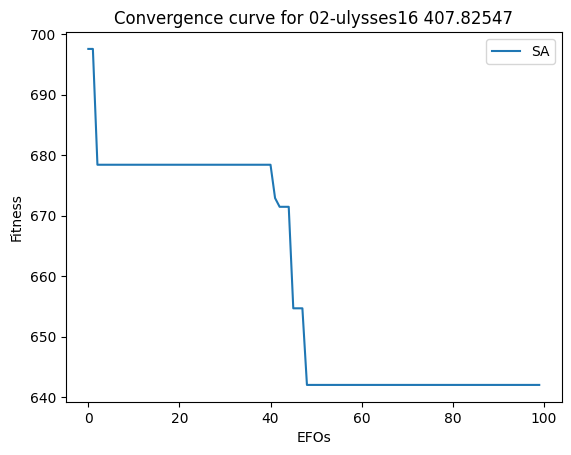

cells:[ 3 15  2 11  4 10 13 14  6  8  9  7  1  0 12  5]-fit:642.01761


In [ ]:
myP1 = tsp(myPath +"02-ulysses16.txt")
print (myP1)
max_efos = 100
sa = SA(max_efos = max_efos)
r3 = sa.evolve(seed=1, problem=myP1)
#print(r2)
plot_convergence_curve(r3, myP1, sa)
print (sa.best)

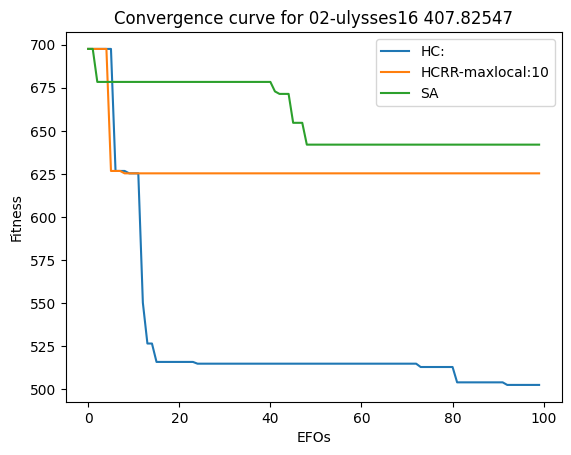

In [ ]:
results = [r1, r2, r3]
alg =[str(hc), str(hcrr), str(sa)]
plot_convergence_curve_comparison(results, myP1, alg)

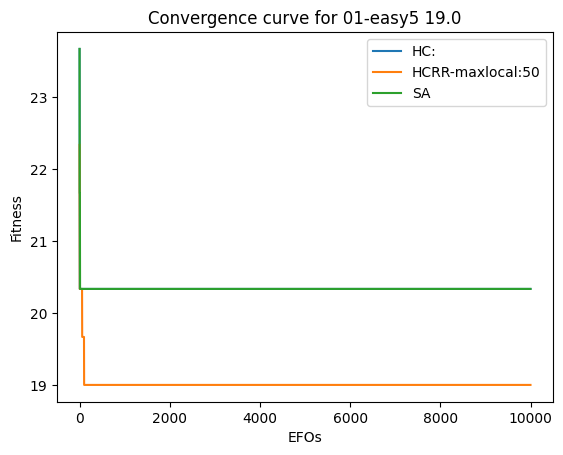

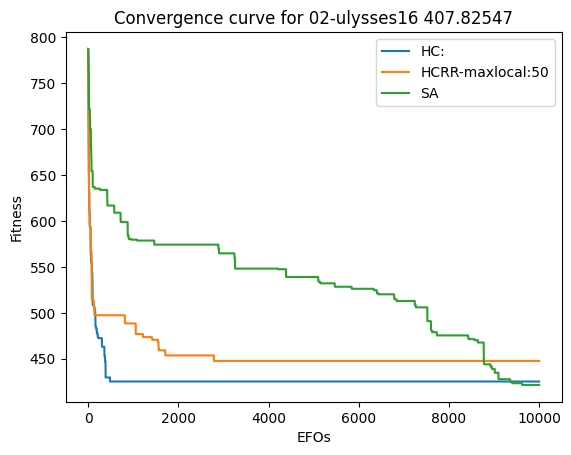

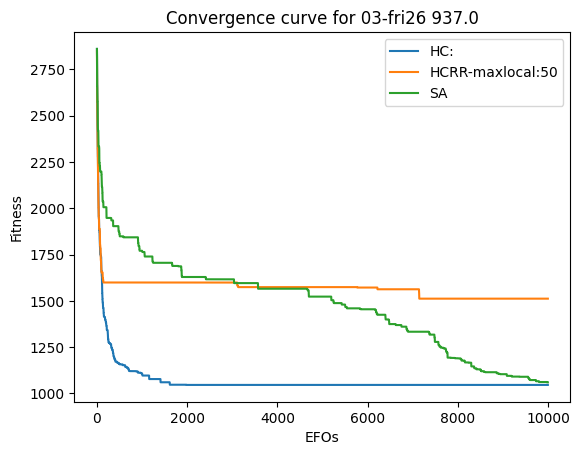

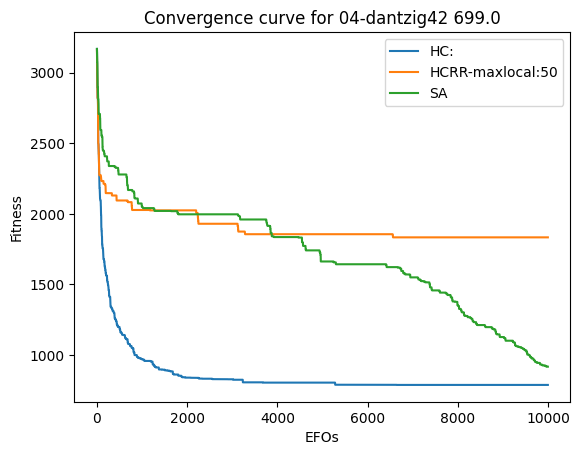

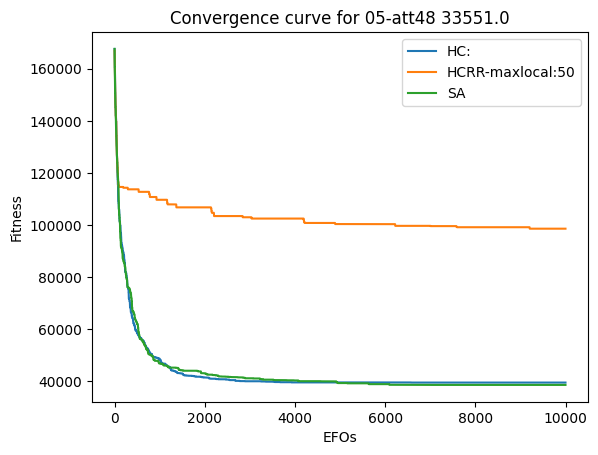

Promedios:
                  Problem                  HC                HCRR  \
0           01-easy5 19.0  20.333333333333332                19.0   
1  02-ulysses16 407.82547  425.28292000000005   447.6690833333333   
2          03-fri26 937.0  1045.6666666666667  1511.6666666666667   
3      04-dantzig42 699.0               787.0              1833.0   
4        05-att48 33551.0             39569.0             98618.0   

                   SA  
0  20.333333333333332  
1   421.5838966666666  
2  1059.6666666666667  
3   916.3333333333334  
4  38664.666666666664  
Desviaciones Estandar:
                  Problem                  HC                HCRR  \
0           01-easy5 19.0  0.9428090415820634                 0.0   
1  02-ulysses16 407.82547   7.191623244122318  10.760614128324123   
2          03-fri26 937.0   58.78964383479647   78.89374006993344   
3      04-dantzig42 699.0  21.354156504062622  34.708308323320324   
4        05-att48 33551.0   1675.321063756636   3416.988245029

In [ ]:
max_efos = 10000
max_local = 50
repetitions = 3
myP1 = tsp(myPath +"01-easy5.txt")
myP2 = tsp(myPath +"02-ulysses16.txt")
myP3 = tsp(myPath +"03-fri26.txt")
myP4 = tsp(myPath +"04-dantzig42.txt")
myP5 = tsp(myPath +"05-att48.txt")
problems = [myP1, myP2, myP3, myP4, myP5]

hc = HC(max_efos = max_efos)
hcrr = HCRR(max_efos= max_efos, max_local = max_local)
sa = SA(max_efos = max_efos)
algorithms = [hc, hcrr, sa]

df = pd.DataFrame({'Problem': pd.Series(dtype='str'),
                   'HC': pd.Series(dtype='float'),
                   'HCRR': pd.Series(dtype='float'),
                   'SA': pd.Series(dtype='float')})
df2 = pd.DataFrame({'Problem': pd.Series(dtype='str'),
                   'HC': pd.Series(dtype='float'),
                   'HCRR': pd.Series(dtype='float'),
                   'SA': pd.Series(dtype='float')})
for p in problems:

  names_alg = []
  avg_curve_alg = []
  best_avg_fitness_alg = []
  best_std_fitness_alg = []

  for alg in algorithms:
    avg_curve = np.zeros(max_efos, float)
    best_fitnes = np.zeros(repetitions, float)

    for s in range(0, repetitions):
      curve_data = alg.evolve(seed=s, problem=p)
      avg_curve = avg_curve + curve_data
      best_fitnes[s] = alg.best.fitness

    avg_curve = avg_curve/ repetitions
    avg_best_fitnes = np.average(best_fitnes)
    std_best_fitnes = np.std(best_fitnes)

    names_alg.append(str(alg))
    avg_curve_alg.append(avg_curve)
    best_avg_fitness_alg.append(avg_best_fitnes)
    best_std_fitness_alg.append(std_best_fitnes)

  plot_convergence_curve_comparison(avg_curve_alg, p, names_alg)

  new_row = pd.DataFrame({'Problem': str(p),
                          'HC':str(best_avg_fitness_alg[0]),
                          'HCRR':str(best_avg_fitness_alg[1]),
                          'SA':str(best_avg_fitness_alg[2])}, index=[0])
  df = pd.concat([df.loc[:], new_row]).reset_index(drop=True)

  new_row2 = pd.DataFrame({'Problem': str(p),
                           'HC':str(best_std_fitness_alg[0]),
                           'HCRR':str(best_std_fitness_alg[1]),
                           'SA':str(best_std_fitness_alg[2])}, index=[0])
  df2 = pd.concat([df2.loc[:], new_row2]).reset_index(drop=True)

print("Promedios:")
print(df)
print("Desviaciones Estandar:")
print(df2)